# FINAL NPZD PROTOTYPE

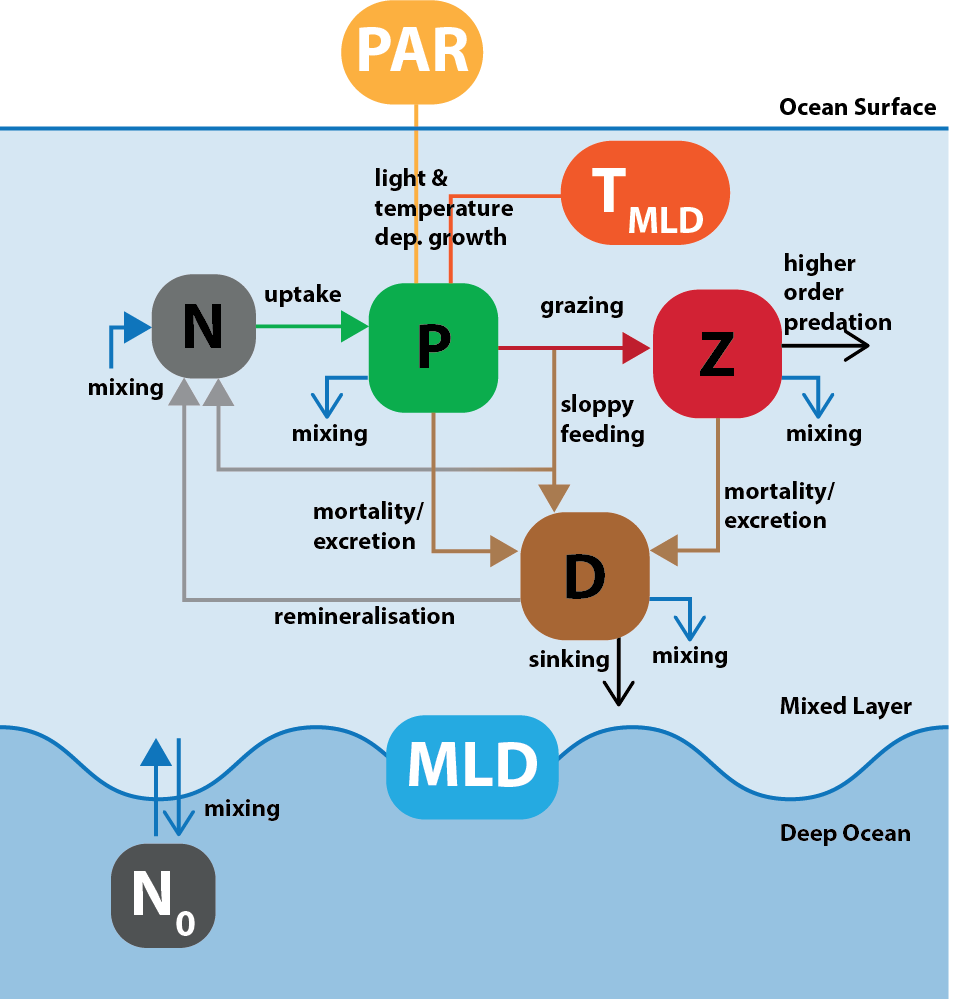

In [1]:
from IPython.display import Image
Image(filename=('NPZDslab_schematics.png'), width=500)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [5]:
from phydra.components.variables import SV

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.growth_multi_lim import Growth_ML, Eppley_ML, Monod_ML, Steele_ML
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import SlabUpwelling, SlabMixing, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing

In [6]:
NPZD = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SV,
    'Zooplankton':SV,
    'Detritus':SV,
    
    # Mixing:
    'Upwelling':SlabUpwelling,
    'Mixing':SlabMixing,
    'Sinking':SlabSinking,

    # Growth
    'Growth':Growth_ML,
    'Monod':Monod_ML,
    'Steele':Steele_ML,
    'Eppley':Eppley_ML,
    
    # Grazing
    'Grazing':HollingTypeIII_ResourcesListInput_Consumption2Group,
    'GGE':GrossGrowthEfficiency,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange,
    'PhytoQuadMortality':QuadraticExchange,
    'ZooLinMortality':LinearExchange,
    'HigherOrderPred':QuadraticDecay,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'N0':GlobalSlabClimatologyForcing,
    'Tmld':GlobalSlabClimatologyForcing,
    'I0':GlobalSlabClimatologyForcing,
    'MLD':GlobalSlabClimatologyForcing,
    'MLDderiv':GlobalSlabClimatologyForcing,
                     })

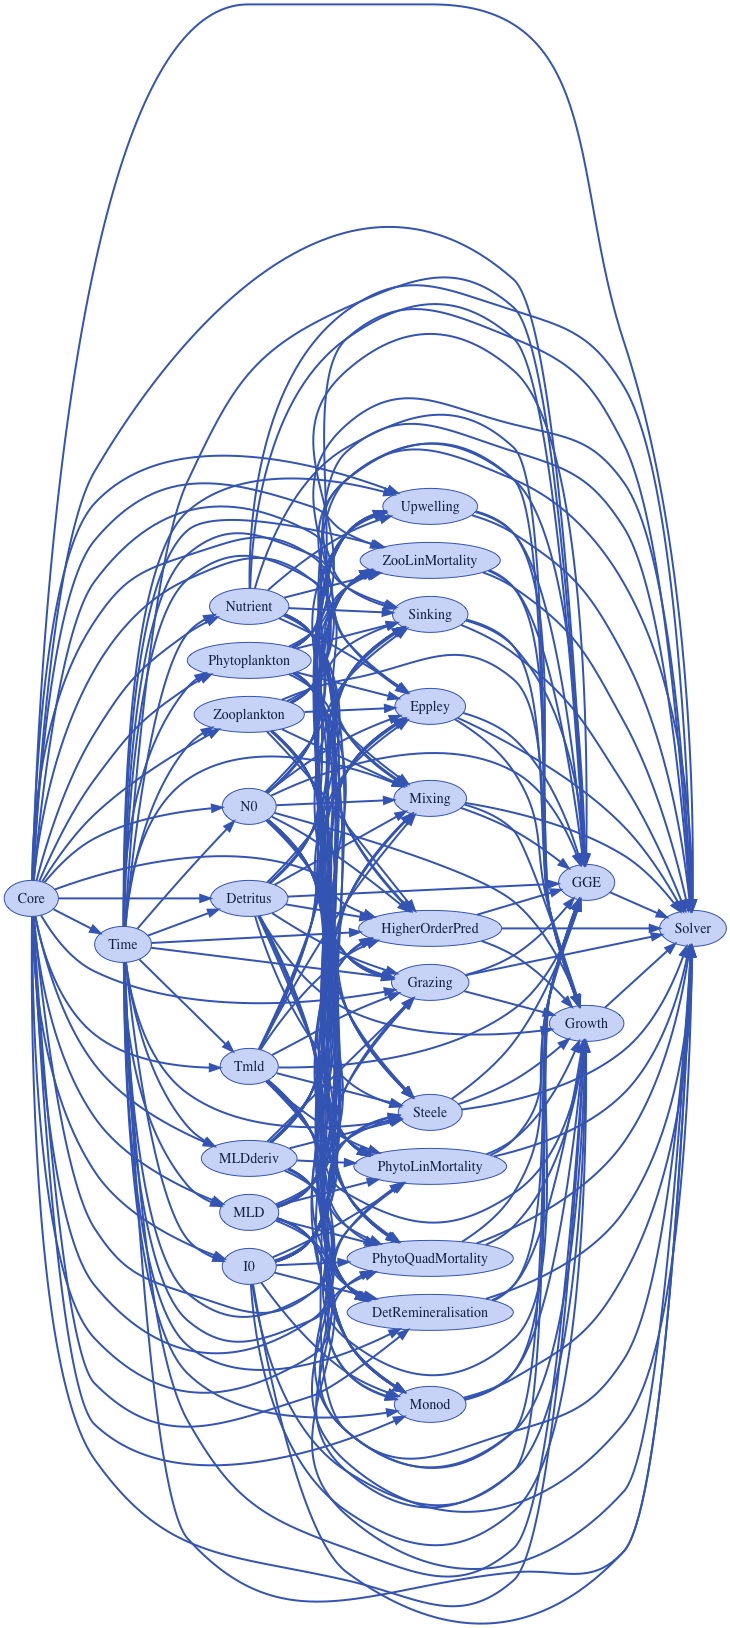

In [7]:
NPZD.visualize()

In [8]:
NPZD

<xsimlab.Model (26 processes, 99 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_init                 [in] initial value / basic state variable
    var_label                [in] label / basic state variable
Zooplankton
    var_init                 [in] initial value / basic state variable
    var_label                [in] label / basic state variable
Detritus
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
N0
    rbb                      [in] constant value of forcing
    k                        [in] The degree of the spline fit
    deriv                    [in] order of derivative to store, for...
    lon                      [in] constant value of forcing
    sm

In [9]:
# Set common location of global slab forcing
forcing_location = {'lat':47,'lon':-20,'rbb':2}

odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,365*5),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':1.},
                    'Phytoplankton':{'var_label':'P','var_init':1.},
                    'Zooplankton':{'var_label':'Z','var_init':1.},
                    'Detritus':{'var_label':'D','var_init':1.},
                
                    # Mixing:
                    'Upwelling':{'n':'N', 'n_0':'N0', 'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Mixing':{'vars_sink':['P','Z','D'], 'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Monod':{'resource':'N', 'halfsat':.85},
                    'Steele':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'i_opt':10},
                    'Eppley':{'temp':'Tmld', 'eppley_exp':0.063},

                    # Grazing
                    'Grazing':{'resources':['P','D'], 'consumer':'Z',
                           'feed_prefs':[.67,.33],'Imax':1., 'kZ':.6},
                    'GGE':{'assimilated_consumer':'Z', 'egested_detritus':'D', 'excreted_nutrient':'N', 
                           'epsilon':0.75, 'beta':0.69},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.1},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.01},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':0.1},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.1},

                    # Forcings
                    'N0':{**forcing_location, 'forcing_label':'N0', 'dataset':'n0x',
                          'smooth':5, 'k':2, 'deriv':0},
                    'Tmld':{**forcing_location, 'forcing_label':'Tmld', 'dataset':'tmld',
                          'smooth':5, 'k':2, 'deriv':0},
                    'I0':{**forcing_location, 'forcing_label':'I0', 'dataset':'par',
                          'smooth':10, 'k':2, 'deriv':0},
                    'MLD':{**forcing_location, 'forcing_label':'MLD', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':0},
                    'MLDderiv':{**forcing_location, 'forcing_label':'MLDderiv', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':1}
            },
            output_vars="ALL"
            )

In [10]:
# odeint_setup

In [11]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
Initializing component MLD
Initializing component I0
Initializing component MLDderiv
Initializing component Tmld
Initializing component Upwelling
Initializing component Mixing
Initializing component Sinking
Initializing component HigherOrderPred
Initializing component Eppley
Initializing component ZooLinMortality
Initializing component DetRemineralisation
Initializing component Monod
Initializing component Grazing
Initializing component Steele
Initializing component PhytoLinMortality
Initializing component PhytoQuadMortality
Initializing component Growth
Initializing component GGE
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x162a7fd30>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['N0_dataset', 'N0_lat', 

In [12]:
odeint_out

<xarray.Dataset>
Dimensions:                           (clock: 2, input_time: 1825, resources: 2, sinking_vars: 3, sinking_vars_full: 3, time: 1825)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: input_time, resources, sinking_vars, sinking_vars_full, time
Data variables:
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (time) float64 0.1 0.09917 ... 0.04731
    DetRemineralisation__rate         float64 0.1
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 1.0
    Detritus__var_label               <U1 'D'
    Detritus__var_value               (time) float64 1.0 0.9608 ... 0.4761
    Eppley__eppley_exp                float64 0.063
    Eppley__eppley_growth_label       <U20 'Eppley_eppley_growth'
    Eppley__eppley_growth_value       (time) float64 2.32 2.318 ... 2.333 2.328
    Eppley__temp                      <U4 'Tmld'
    GGE__assimilated_consumer         <U1 'Z'
    GGE__assimilation_value           (time) float64 0.3805 0.3384 ... 2e-07
    GGE__beta                         float64 0.69
    GGE__egested_detritus             <U1 'D'
    GGE__egestion_value               (time) float64 0.2279 0.2027 ... 1e-07
    GGE__epsilon                      float64 0.75
    GGE__excreted_nutrient            <U1 'N'
    GGE__excretion_value              (time) float64 0.1268 0.1128 ... 0.0 1e-07
    Grazing__Imax                     float64 1.0
    Grazing__consumer                 <U1 'Z'
    Grazing__feed_prefs               (resources) float64 0.67 0.33
    Grazing__grazing_label            <U15 'Grazing_grazing'
    Grazing__grazing_value            (resources, time) float64 0.4926 ... 1e-07
    Grazing__kZ                       float64 0.6
    Grazing__resources                (resources) <U1 'P' 'D'
    Growth__consumer                  <U1 'P'
    Growth__growth_value              (time) float64 0.1605 0.1447 ... 0.09336
    Growth__mu_max                    float64 1.0
    Growth__resource                  <U1 'N'
    HigherOrderPred__decay_value      (time) float64 0.34 0.3137 ... 0.0 0.0
    HigherOrderPred__rate             float64 0.34
    HigherOrderPred__var              <U1 'Z'
    I0__dataset                       <U3 'par'
    I0__deriv                         int64 0
    I0__forcing_label                 <U2 'I0'
    I0__forcing_value                 (time) float64 7.521 7.594 ... 7.388 7.452
    I0__k                             int64 2
    I0__lat                           int64 47
    I0__lon                           int64 -20
    I0__rbb                           int64 2
    I0__smooth                        int64 10
    MLD__dataset                      <U3 'mld'
    MLD__deriv                        int64 0
    MLD__forcing_label                <U3 'MLD'
    MLD__forcing_value                (time) float64 160.4 162.2 ... 156.8 158.6
    MLD__k                            int64 2
    MLD__lat                          int64 47
    MLD__lon                          int64 -20
    MLD__rbb                          int64 2
    MLD__smooth                       int64 400
    MLDderiv__dataset                 <U3 'mld'
    MLDderiv__deriv                   int64 1
    MLDderiv__forcing_label           <U8 'MLDderiv'
    MLDderiv__forcing_value           (time) float64 1.818 1.78 ... 1.795 1.806
    MLDderiv__k                       int64 2
    MLDderiv__lat                     int64 47
    MLDderiv__lon                     int64 -20
    MLDderiv__rbb                     int64 2
    MLDderiv__smooth                  int64 400
    Mixing__kappa                     float64 0.13
    Mixing__mixing_value              (sinking_vars_full, time) float64 0.012...
    Mixing__mld                       <U3 'MLD'
    Mixing__mld_deriv                 <U8 'MLDderiv'
    Mixing__vars_sink                 (sinking_vars) <U1 'P' 'Z' 'D'
    Monod__halfsat 

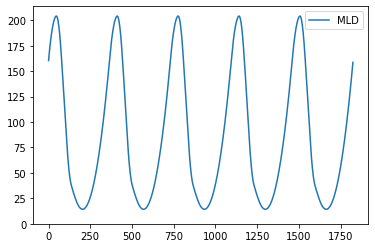

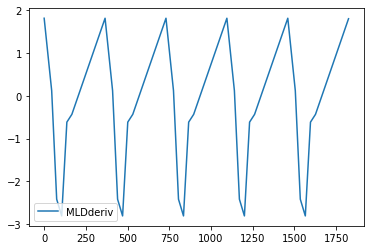

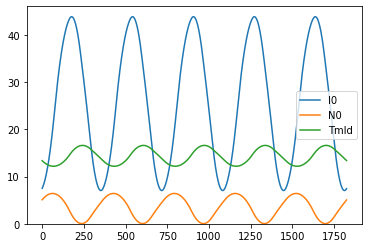

In [13]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, odeint_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, odeint_out.I0__forcing_value, label='I0')
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.plot(time, odeint_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()

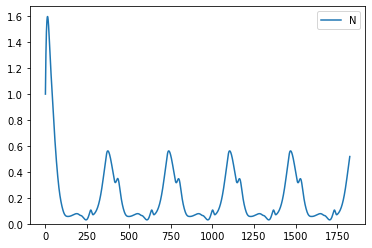

In [14]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

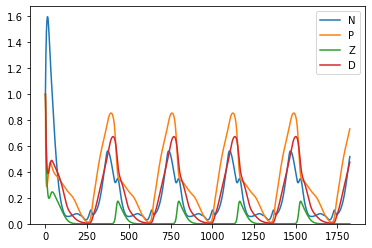

In [15]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

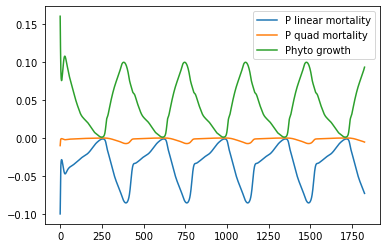

In [16]:
plt.plot(time, -odeint_out.PhytoLinMortality__decay_value, label='P linear mortality')
plt.plot(time, -odeint_out.PhytoQuadMortality__decay_value, label='P quad mortality')
plt.plot(time, odeint_out.Growth__growth_value, label='Phyto growth')

plt.legend()

In [17]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise",
                                     new_time=np.arange(0,365*5,.5))

In [18]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
flux Time_time_flux (3650,)
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
Initializing component MLD
Initializing component I0
Initializing component MLDderiv
Initializing component Tmld
Initializing component Upwelling
flux Upwelling_mixing (3650,)
Initializing component Mixing
flux Mixing_mixing (3, 3650)
Initializing component Sinking
flux Sinking_sinking (3650,)
Initializing component HigherOrderPred
flux HigherOrderPred_decay (3650,)
Initializing component Eppley
flux Eppley_eppley_growth (3650,)
Initializing component ZooLinMortality
flux ZooLinMortality_decay (3650,)
Initializing component DetRemineralisation
flux DetRemineralisation_decay (3650,)
Initializing component Monod
flux Monod_monod_lim (3650,)
Initializing component Grazing
flux Grazing_grazing (2, 3650)
Initializing component Steele
flux Steele_steele_l

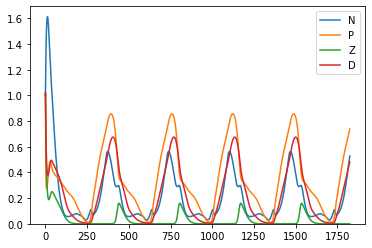

In [19]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

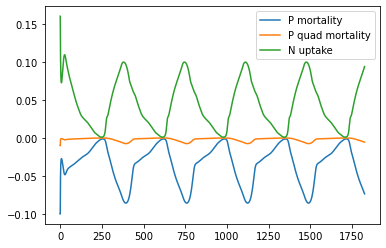

In [20]:
#plt.plot(time, stepwise_out.Input__input_value, label='N_input')
plt.plot(time, -stepwise_out.PhytoLinMortality__decay_value, label='P mortality')
plt.plot(time, -stepwise_out.PhytoQuadMortality__decay_value, label='P quad mortality')
plt.plot(time, stepwise_out.Growth__growth_value, label='N uptake')
#plt.plot(time, stepwise_out.Grazing__grazing_value, label='Grazing')
#plt.ylim(bottom=0)
plt.legend()

In [21]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [22]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
Initializing component MLD
Initializing component I0
Initializing component MLDderiv
Initializing component Tmld
Initializing component Upwelling
Initializing component Mixing
Initializing component Sinking
Initializing component HigherOrderPred
Initializing component Eppley
Initializing component ZooLinMortality
Initializing component DetRemineralisation
Initializing component Monod
Initializing component Grazing
Initializing component Steele
Initializing component PhytoLinMortality
Initializing component PhytoQuadMortality
Initializing component Growth
Initializing component GGE
assembling model
SOLVER : <phydra.backend.solvers.GEKKOSolver object at 0x16a3f54f0>
Model dicts are assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['N0_dataset', 'N0_

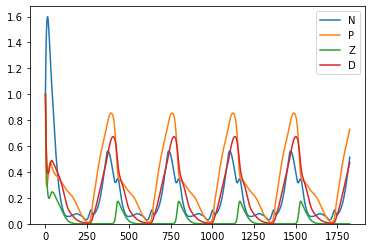

In [23]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

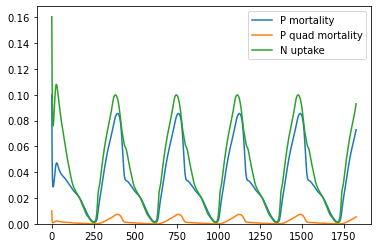

In [24]:
plt.plot(time, gekko_out.PhytoLinMortality__decay_value, label='P mortality')
plt.plot(time, gekko_out.PhytoQuadMortality__decay_value, label='P quad mortality')
plt.plot(time, gekko_out.Growth__growth_value, label='N uptake')
#plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()